<a href="https://colab.research.google.com/github/Pdeep666/ML/blob/main/Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
from google.colab import files

# Upload CSV file
uploaded = files.upload()


Saving PJME_hourly.csv to PJME_hourly (2).csv


In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [96]:
df=pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [97]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [98]:
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)

In [99]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


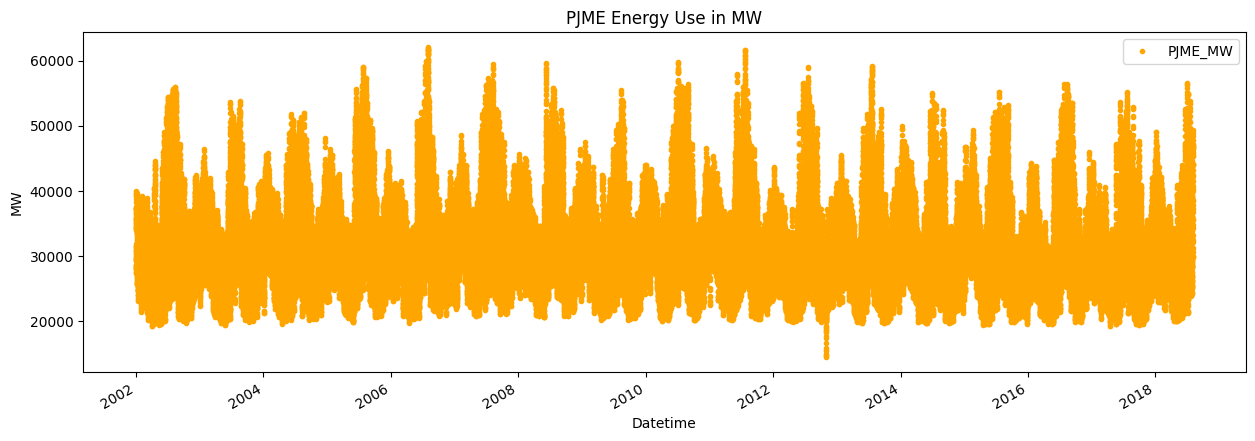

In [100]:
df.plot(style='.', figsize=(15, 5), color='orange')
plt.title('PJME Energy Use in MW')
plt.ylabel('MW')
plt.show()

In [101]:
train=df.iloc[df.index < '2015-01-01']
test=df.iloc[df.index >='2015-01-01']

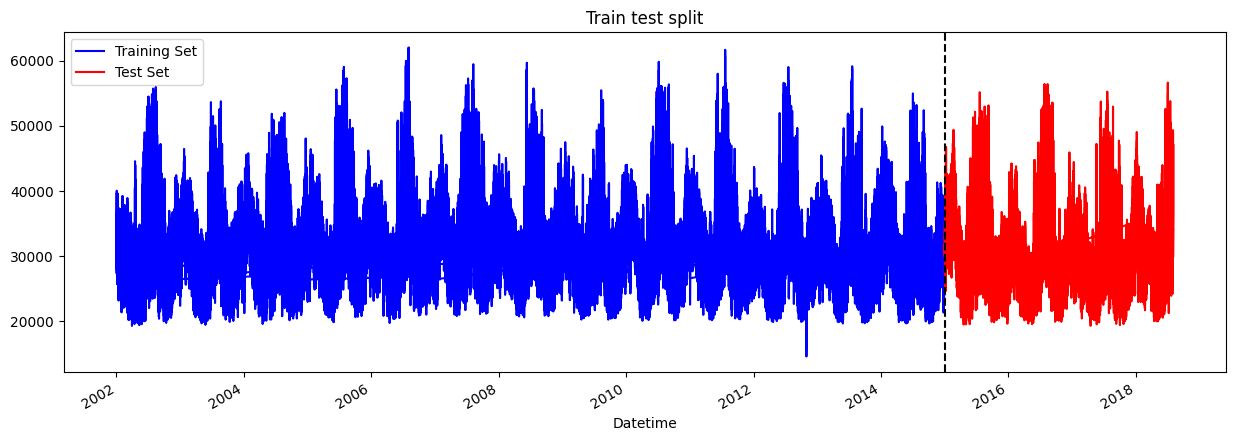

In [102]:
fig, ax=plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', color='blue',title='Train test split')
test.plot(ax=ax, label='Test Set', color='red')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

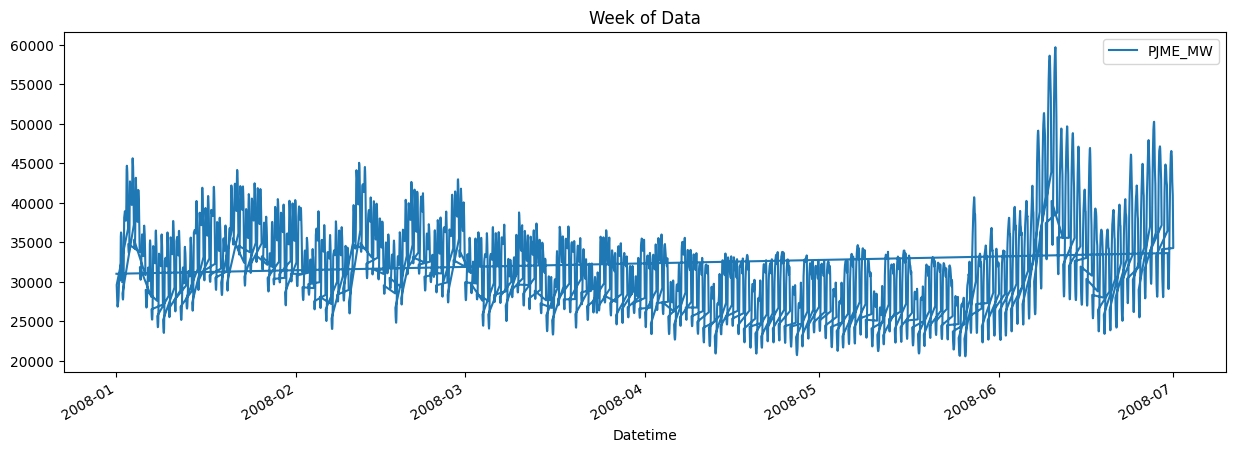

In [103]:
df.loc[(df.index>='01-01-2008') &(df.index<='07-01-2008')].plot(figsize=(15, 5), title='Week of Data')

In [104]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    return df
df=create_features(df)

Text(0, 0.5, 'MW')

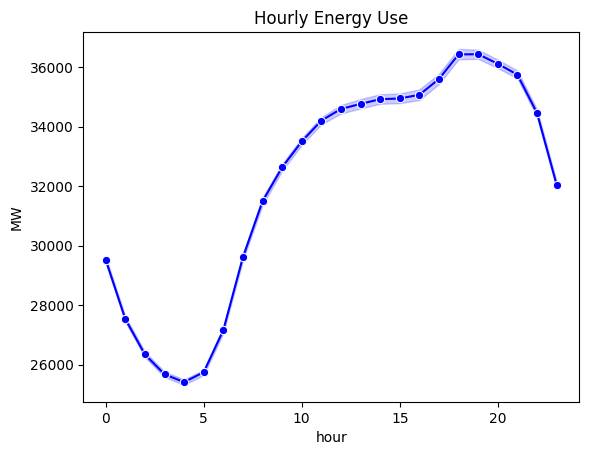

In [105]:
sns.lineplot(x='hour', y='PJME_MW', data=df, marker='o',color='blue')
plt.title('Hourly Energy Use')
plt.ylabel('MW')

Text(0, 0.5, 'MW')

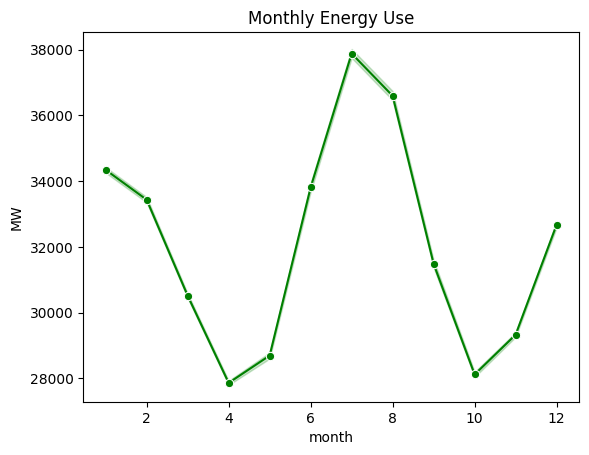

In [106]:
sns.lineplot(x='month', y='PJME_MW', data=df, marker='o',color='green')
plt.title('Monthly Energy Use')
plt.ylabel('MW')

Text(0, 0.5, 'MW')

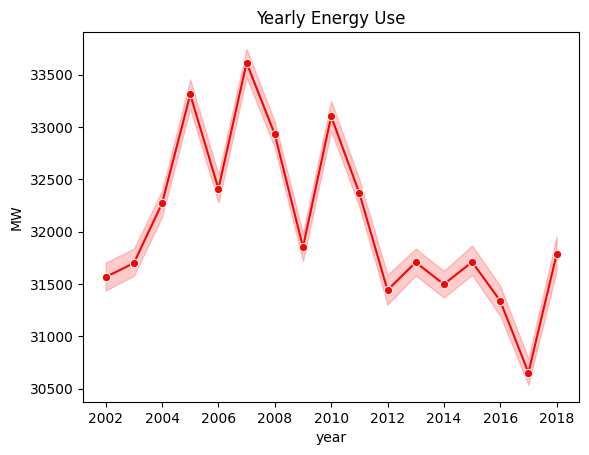

In [107]:
sns.lineplot(x='year', y='PJME_MW', data=df, marker='o',color='red')
plt.title('Yearly Energy Use')
plt.ylabel('MW')

In [108]:
train=create_features(train)
test=create_features(test)

<ipython-input-104-c94b9575d70b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-104-c94b9575d70b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-104-c94b9575d70b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [109]:
df.columns

Index(['PJME_MW', 'date', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth'],
      dtype='object')

In [110]:
features=['hour', 'dayofweek','month']
target=['PJME_MW']

In [111]:
x_train=train[features]
y_train=train[target]
x_test=test[features]
y_test=test[target]

In [112]:
import xgboost as xgb

# Initialize the XGBRegressor model
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.001)

# Fit the model with early stopping
reg.fit(
    x_train, y_train,  # training data
    eval_set=[(x_train, y_train), (x_test, y_test)],  # validation data for early stopping
    verbose=100  # set to True to see the evaluation results for each boosting round
)


[0]	validation_0-rmse:6447.91782	validation_1-rmse:6517.64118
[100]	validation_0-rmse:6041.32303	validation_1-rmse:6138.72106
[200]	validation_0-rmse:5686.86670	validation_1-rmse:5812.69640
[300]	validation_0-rmse:5377.19591	validation_1-rmse:5532.33901
[400]	validation_0-rmse:5108.08606	validation_1-rmse:5292.09052
[500]	validation_0-rmse:4874.13638	validation_1-rmse:5085.99846
[600]	validation_0-rmse:4662.61627	validation_1-rmse:4900.40293
[700]	validation_0-rmse:4479.14230	validation_1-rmse:4740.96998
[800]	validation_0-rmse:4320.95327	validation_1-rmse:4605.73126
[900]	validation_0-rmse:4185.54835	validation_1-rmse:4492.09258
[999]	validation_0-rmse:4070.15316	validation_1-rmse:4397.05886


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [113]:
feature_importances = reg.feature_importances_

# If you have feature names, you can pair them with the importances
# For example, assuming 'X_train' has the feature names
features = x_train.columns  # Use your own feature names here

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Round the importances to 2 decimals
importance_df['Importance'] = importance_df['Importance'].round(5)

# Sort the dataframe by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)

     Feature  Importance
0       hour     0.53631
2      month     0.27304
1  dayofweek     0.19065


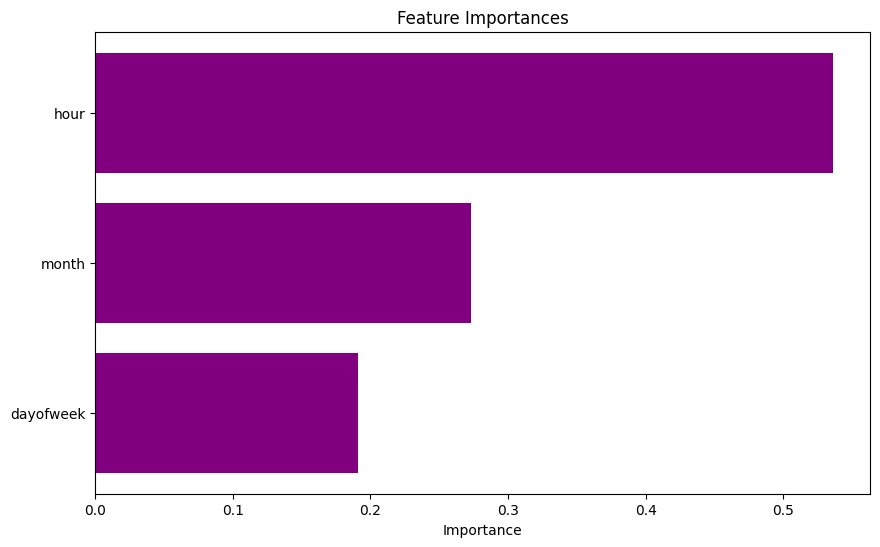

In [114]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='purple')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [115]:
test['predition']=reg.predict(x_test)

<ipython-input-115-b02c8a4bb4ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predition']=reg.predict(x_test)


In [116]:
df=df.merge(test[['predition']], how='left', left_index=True, right_index=True)

In [117]:
df

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,predition
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,NaN
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,NaN
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,NaN
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,NaN
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018-01-01 20:00:00,20,0,1,1,2018,1,1,35938.949219
2018-01-01 21:00:00,43751.0,2018-01-01 21:00:00,21,0,1,1,2018,1,1,35938.949219
2018-01-01 22:00:00,42402.0,2018-01-01 22:00:00,22,0,1,1,2018,1,1,35164.359375


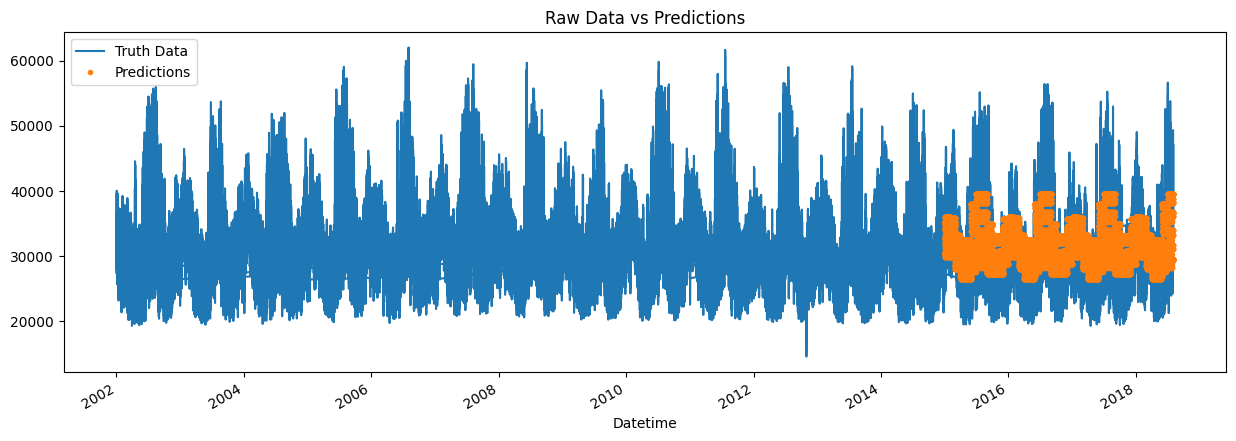

In [118]:
ax=df[['PJME_MW']].plot(figsize=(15,5))
df['predition'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
plt.title('Raw Data vs Predictions')
plt.show()

In [119]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_train_pred = reg.predict(x_train)
y_test_pred = reg.predict(x_test)

# Compute R² score (coefficient of determination)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print R² score (Accuracy for regression)
print(f"Training R² (Accuracy): {train_r2:.2f}")
print(f"Test R² (Accuracy): {test_r2:.2f}")


Training R² (Accuracy): 0.60
Test R² (Accuracy): 0.54


In [120]:
'''
The function computes the R² score, which is the proportion of the variance in the dependent variable that is predictable from the independent variables. It gives a measure of how well the model fits the data.
  R² = 1: Perfect prediction (model explains all the variance).
  R² = 0: Model explains none of the variance.
  Negative R²: Indicates that the model is worse than a baseline model (e.g., predicting the mean of the target).
'''

'\nThe function computes the R² score, which is the proportion of the variance in the dependent variable that is predictable from the independent variables. It gives a measure of how well the model fits the data.\n  R² = 1: Perfect prediction (model explains all the variance).\n  R² = 0: Model explains none of the variance.\n  Negative R²: Indicates that the model is worse than a baseline model (e.g., predicting the mean of the target).\n'